In [1]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
# from traj_run import rho_ohmic
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter, \
    amp_func, freq_func, fit_amp_singnal, fit_freq_singnal

from scipy.optimize import curve_fit

2024-12-05 22:48:50,777[INFO] Use NumPy as backend
2024-12-05 22:48:50,777[INFO] numpy random seed is 9012
2024-12-05 22:48:50,777[INFO] random seed is 1092
2024-12-05 22:48:50,779[INFO] Git Commit Hash: 1ee44206c9587652113a95356a9ba742d73b1a17
2024-12-05 22:48:50,779[INFO] use 64 bits


In [2]:

mother_folder = '/home/ansatz/data/comp/sbm/24_09_28'
nsteps = 500

In [3]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    key = line

    vn_entropy_1site_all_lines[key] = points

-----


In [4]:
for key in vn_entropy_1site_all_lines.keys():
    print(key)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [5]:
def get_freq_cft_xf_yf(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=0.7, alpha=0.4, nmodes=1000, rho_type=0, nsteps=100,
                  idof=504):
    v_dof = data = get_data_of_dof(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps,
                  idof=idof)
    signal = wavelet_denoising(v_dof)
    N = 1001
    xf, yf = do_cft(np.linspace(0, 10, 100), signal, N)

    plt.clf()

    
    amp = 2.0/N * np.abs(yf)

    plt.title(f's_{s}-alpha_{alpha}-nmodes_{nmodes}-rho_type_{rho_type}-nsteps_{nsteps}')
    plt.plot(xf, amp, label=f'v_{idof}')
    indexs , _ = scipy.signal.find_peaks(amp)
    
    if len(indexs) != 0 : 
        peaks = [ amp[index] for index in indexs ]
        freqs = [ xf[index] for index in indexs ]
        with open(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.pickle', 'wb') as f:
            pickle.dump([freqs, peaks], f)
        # index = indexs[peaks.index(max(peaks))]
        # index = indexs[0]
        # print(peaks.index(max(peaks)), index)
        # index = indexs[0]
        # freq =  xf[index]
        # amplitude = amp[index]
        # amplitude = 2.0/N * np.abs(yf[index])
        # phase = np.angle(np.abs(yf[index]))
        # print(freq, amplitude)
        sorted_peaks = sorted(peaks, reverse=True)
        index = indexs[peaks.index(sorted_peaks[0])]
        freq =  xf[index]
        amplitude = amp[index]
        plt.scatter(freq, amplitude, color='red')
        plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        if len(indexs) >= 1:
            index = indexs[peaks.index(sorted_peaks[1])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))

        if len(indexs) >= 2:
            index = indexs[peaks.index(sorted_peaks[2])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        plt.legend()
        plt.savefig(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.png')
        # plt.clf()
        return freq
    else:
        return 0


def r_squared(x,y, param_list, func):
    mean = np.mean(y)  # 1.y mean

    ss_tot = np.sum((y - mean) ** 2)  # 2.total sum of squares

    ss_res = np.sum((y - func(x, *param_list)) ** 2)  # 3.residual sum of squares

    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [6]:
ids = [ i for i in range(1000) if (i+1)%5==0 and i > 39 and i < 630]


In [7]:
bond_dims

20

In [8]:
s=0.5
alpha=0.80
nmodes=1000
rho_type=0
nstep=500   
Omega=1
omega_c=10
td_method=0
bond_dims=20


job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

key =job_name

omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nsteps=nstep)

In [9]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [10]:
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])
a, b = fit_freq_singnal(dats)
r_2 = r_squared(x, y_true, [a, b], freq_func)

Text(0.1, 0.1, 'y = 0.158911 * x + -0.000183, R**2: 1.000')

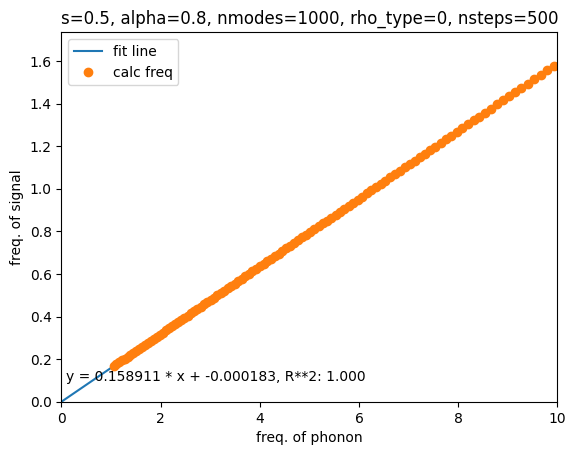

In [11]:
func_x = np.linspace(0, 10, 500)
func_y = a * func_x + b
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc freq')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')
plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('freq. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.1, y=0.1, s=f'y = {a:3f} * x + {b:3f}, R**2: {r_2:.3f}')

In [12]:
dats = [ get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630 ]

In [13]:
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])
a, b, c = fit_amp_singnal(dats)


Text(0.1, 0.1, 'y = 2.006 * exp(-0.969*x) + 0.025 ')

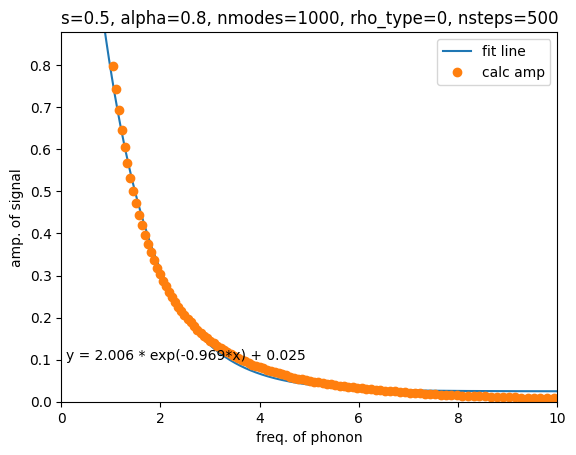

In [14]:
func_x = np.linspace(0, 10, 500)
func_y = amp_func(func_x, a, b, c)
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc amp')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')


plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('amp. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()

plt.text(x=0.1, y=0.1, s=f'y = {a:.3f} * exp({b:.3f}*x) + {c:.3f} ')

In [15]:
dats[0][2]

[0.7988588732587405,
 0.7991532374744574,
 0.7991466118677165,
 0.7993376890658326,
 0.7989901369210167,
 0.7988778526852707,
 0.7987541380607455]

In [16]:
np.std(np.array(dats[0][2]))

0.00018988169171758673

In [17]:
def draw_freq_plot_withfit(s, alpha, mother_folder, data_dict, plot=False ):
    # s=0.5
    # alpha=0.80
    nmodes=1000
    rho_type=0
    nstep=500   
    Omega=1
    omega_c=10
    td_method=0
    bond_dims=20


    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name

    # omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, data_dict, key, nsteps=nstep)
    
    dats = [ get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 39 and i < 630 ]    
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])

    a, b = fit_freq_singnal(dats)
    r_2 = r_squared(x, y_true, [a, b], freq_func)

    if plot:
        func_x = np.linspace(0, 10, 500)
        func_y = a * func_x + b
        plt.plot(func_x, func_y , label=f's{s:.02f}-alpha{alpha:.02f}_fit line')
        plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label=f's{s:.02f}-alpha{alpha:.02f}_calc freq')
        plt.xlim(0, 10)
        plt.xlabel('freq. of phonon')
        plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
        plt.ylabel('freq. of signal')
        plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
        # plt.legend(draggable=True)
        # plt.text(x=0.1, y=0.1, s=f'y = {a:3f} * x + {b:3f}, R**2: {r_2:.3f}')
    return (a, b, r_2)

In [18]:
def draw_amp_plot_withfit(s, alpha, mother_folder, data_dict , plot=False):
    # s=0.5
    # alpha=0.80
    nmodes=1000
    rho_type=0
    nstep=500   
    Omega=1
    omega_c=10
    td_method=0
    bond_dims=20


    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name

    # omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, data_dict, key, nsteps=nstep)
    dats = [get_signal_amp(mother_folder=mother_folder, data_dict=data_dict, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 39 and i < 630]
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])

    a, b, c = fit_amp_singnal(dats)
    # y_true = np.array([ _[1] for _ in dats ])
    # x = np.array([ _[0] for _ in dats ])
    if plot:
        func_x = np.linspace(0, 10, 500)
        func_y = amp_func(func_x, a, b, c)
        plt.plot(func_x, func_y , label=f's{s:.02f}-alpha{alpha:.02f}_fit line')
        plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label=f's{s:.02f}-alpha{alpha:.02f}_calc amp')
        plt.xlim(0, 10)
        plt.xlabel('freq. of phonon')
    
    
        plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
        plt.ylabel('amp. of signal')
        plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
        # plt.legend(draggable=True)
    
        # plt.text(x=0.1, y=0.1, s=f'y = {a:.3f} * exp({b:.3f}*x) + {c:.3f} ')
    return (a, b, c)

In [19]:
def draw_amp_plot_withlog(s, alpha, mother_folder, data_dict , plot=False):
    # s=0.5
    # alpha=0.80
    nmodes=1000
    rho_type=0
    nstep=500   
    Omega=1
    omega_c=10
    td_method=0
    bond_dims=20


    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name

    # omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, data_dict, key, nsteps=nstep)
    dats = [get_signal_amp(mother_folder=mother_folder, data_dict=data_dict, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 39 and i < 630]
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])

    # a, b, c = fit_amp_singnal(dats)
    y_true = np.array([ _[1] for _ in dats ])
    x = np.array([ _[0] for _ in dats ])
    if plot:
        # func_x = np.linspace(0, 10, 500)
        # func_y = amp_func(func_x, a, b, c)
        # plt.plot(func_x, func_y , label=f's{s:.02f}-alpha{alpha:.02f}_fit line')
        plt.plot([ _[0] for _ in dats ], np.log(np.array([ _[1] for _ in dats ])),'-', label=f's{s:.02f}-alpha{alpha:.02f} o')
        plt.plot([ _[0] for _ in dats ], np.log(np.array([ _[1] for _ in dats ])),'o', label=f's{s:.02f}-alpha{alpha:.02f} -')
        plt.xlim(0, 10)
        plt.xlabel('freq. of phonon')
    
    
        # plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
        plt.ylabel('amp. of signal')
        plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
        # plt.legend(draggable=True)
    
        # plt.text(x=0.1, y=0.1, s=f'y = {a:.3f} * exp({b:.3f}*x) + {c:.3f} ')
    return (a, b, c)

(0.1589059888281557, -0.00014816333700721243, 0.9999999556193744)

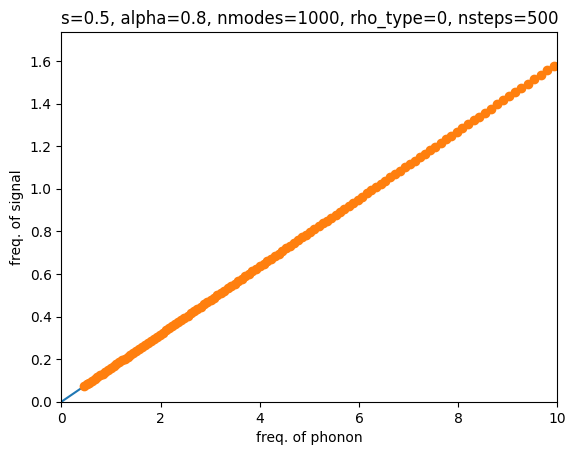

In [20]:
draw_freq_plot_withfit(0.5, 0.8, mother_folder, vn_entropy_1site_all_lines, True)

(0.1589059888281557, -0.00014816333700721243, 0.9999999556193744)

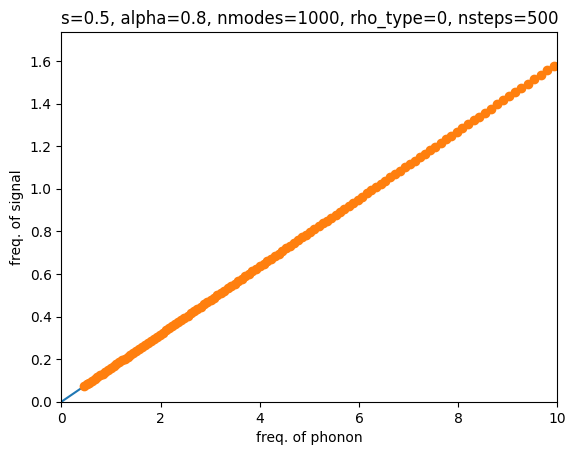

In [21]:
draw_freq_plot_withfit(0.5, 0.8, mother_folder, vn_entropy_1site_all_lines, True)

In [22]:
with open('incoherent_points.pickle', 'rb') as f:
    incoherent_points = pickle.load(f)

with open('pseudo_coherent_points.pickle', 'rb') as f:
    pseudo_coherent_points = pickle.load(f)

with open('coherent_points.pickle', 'rb') as f:
    coherent_points = pickle.load(f)

In [23]:
incoherent_points

[(0.55, 0.2),
 (0.6, 0.2),
 (0.6, 0.25),
 (0.65, 0.2),
 (0.65, 0.25),
 (0.65, 0.3),
 (0.7, 0.2),
 (0.7, 0.25),
 (0.7, 0.3),
 (0.7, 0.35),
 (0.7, 0.4),
 (0.7, 0.45),
 (0.75, 0.25),
 (0.75, 0.3),
 (0.75, 0.35),
 (0.75, 0.4),
 (0.75, 0.45),
 (0.75, 0.5),
 (0.75, 0.6),
 (0.8, 0.25),
 (0.8, 0.3),
 (0.8, 0.35),
 (0.8, 0.4),
 (0.8, 0.45),
 (0.8, 0.5),
 (0.8, 0.55),
 (0.8, 0.6),
 (0.8, 0.65),
 (0.8, 0.7),
 (0.8, 0.75),
 (0.8, 0.8),
 (0.8, 0.85),
 (0.8, 0.9),
 (0.85, 0.3),
 (0.85, 0.35),
 (0.85, 0.4),
 (0.85, 0.45),
 (0.85, 0.5),
 (0.85, 0.55),
 (0.85, 0.6),
 (0.85, 0.65),
 (0.85, 0.7),
 (0.85, 0.75),
 (0.85, 0.8),
 (0.85, 0.85),
 (0.85, 0.9),
 (0.85, 0.95),
 (0.9, 0.35),
 (0.9, 0.4),
 (0.9, 0.45),
 (0.9, 0.5),
 (0.9, 0.55),
 (0.9, 0.6),
 (0.9, 0.65),
 (0.9, 0.7),
 (0.9, 0.75),
 (0.9, 0.8),
 (0.9, 0.85),
 (0.9, 0.9),
 (0.9, 0.95),
 (0.95, 0.4),
 (0.95, 0.45),
 (0.95, 0.5),
 (0.95, 0.55),
 (0.95, 0.6),
 (0.95, 0.65),
 (0.95, 0.7),
 (0.95, 0.75),
 (0.95, 0.8),
 (0.95, 0.85),
 (0.95, 0.9),
 (0.95,

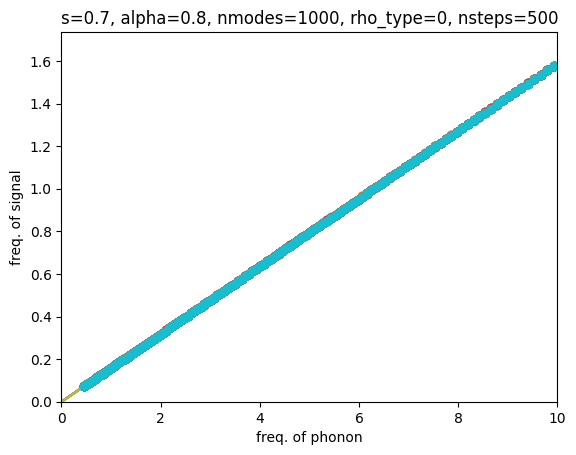

In [24]:
pseudo_coherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        pseudo_coherent_points_freq_fit_results[key] = (a, b)

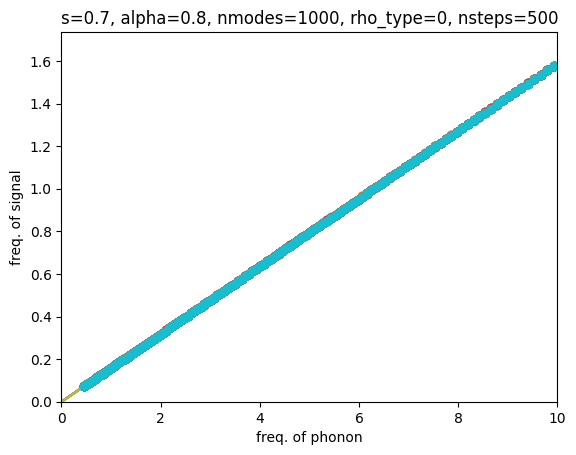

In [25]:
pseudo_coherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        pseudo_coherent_points_freq_fit_results[key] = (a, b)

In [26]:
pseudo_coherent_points_freq_fit_results

{'traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15906502065196645,
  -0.00024816620459149926),
 'traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15902116161683427,
  -0.00023400792152022997),
 'traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15899047112081552,
  -0.00023024237571072425),
 'traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15889244637807493,
  -0.00013039149182339843),
 'traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15903495599189654,
  -5.283770927472279e-05),
 'traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15901295582738592,
  -8.257934317309031e-05),
 'traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15899207562670326,
  -0.00010475133112853608),
 'traj_s0.40_alpha0.80_Omega1_omega_

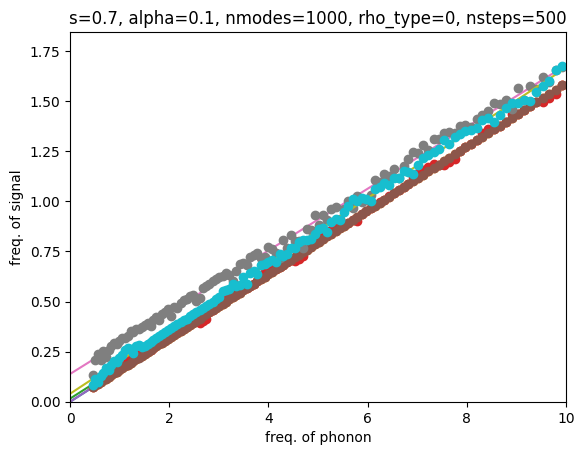

In [27]:
coherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in coherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        coherent_points_freq_fit_results[key] = (a, b)

In [28]:
coherent_points_freq_fit_results

{'traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15914905456851247,
  -0.000431193782423783),
 'traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15733298226507236,
  0.015371986997693316),
 'traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15914987250753262,
  -0.00041717918414307644),
 'traj_s0.70_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15404904686286847,
  0.1383898229712318),
 'traj_s0.70_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.16269375547927473,
  0.03965764499351409)}

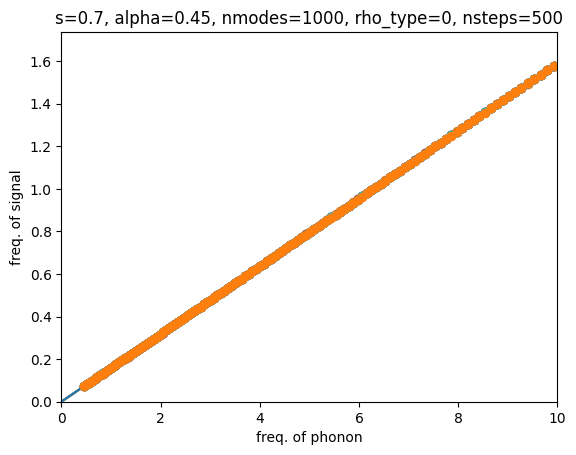

In [29]:
incoherent_points_freq_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in incoherent_points:
        parms = draw_freq_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        r_2 = parms[2]
        key = line  

        incoherent_points_freq_fit_results[key] = (a, b)


In [30]:
incoherent_points_freq_fit_results

{'traj_s0.70_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15911881430367847,
  -9.008344016089998e-05),
 'traj_s0.70_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15907367663595953,
  0.0001185857101884817),
 'traj_s0.70_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15902234482561114,
  0.00031385588089634034),
 'traj_s0.70_alpha0.35_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15900123538157238,
  0.000321355692177357),
 'traj_s0.70_alpha0.40_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15898822466759444,
  0.000276710856485482),
 'traj_s0.70_alpha0.45_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (0.15898412297842998,
  0.00019044006064779242)}

## AMP


In [31]:
nstep = 500 
pseudo_coherent_points_amp_degree_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in pseudo_coherent_points:
        omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nsteps=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 39 and i < 630]
        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        pseudo_coherent_points_amp_degree_results[key] = buffer


    

In [32]:
for key in pseudo_coherent_points_amp_degree_results:
    value = pseudo_coherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.10-alpha0.10, 0.0973, 0.0165
s0.10-alpha0.15, 0.0296, 0.0049
s0.10-alpha0.20, 0.0093, 0.0017
s0.30-alpha0.80, 0.0000, 0.0000
s0.40-alpha0.20, 0.0379, 0.0089
s0.40-alpha0.25, 0.0200, 0.0046
s0.40-alpha0.30, 0.0000, 0.0000
s0.40-alpha0.80, 0.0000, 0.0000
s0.50-alpha0.80, 0.0000, 0.0000
s0.70-alpha0.80, 0.0000, 0.0000


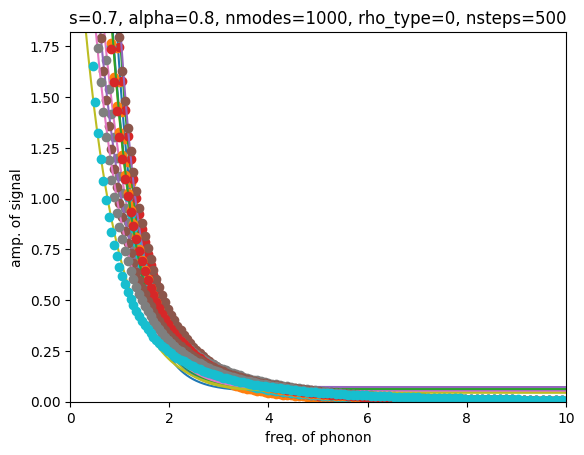

In [33]:


pseudo_coherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        pseudo_coherent_points_amp_fit_results[key] = (a, b, c)



In [34]:
pseudo_coherent_points_amp_fit_results.keys().__len__()

10

In [35]:
for key in pseudo_coherent_points_amp_fit_results:
    value = pseudo_coherent_points_amp_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.10-alpha0.10, 14.4038, -2.2142, 0.0515
s0.10-alpha0.15, 16.2745, -2.2272, 0.0690
s0.10-alpha0.20, 15.1986, -2.1227, 0.0722
s0.30-alpha0.80, 4.8415, -1.4580, 0.0529
s0.40-alpha0.20, 9.1222, -1.9245, 0.0501
s0.40-alpha0.25, 9.2032, -1.9186, 0.0584
s0.40-alpha0.30, 8.8414, -1.8936, 0.0618
s0.40-alpha0.80, 4.3535, -1.4759, 0.0519
s0.50-alpha0.80, 3.8119, -1.4708, 0.0496
s0.70-alpha0.80, 2.7951, -1.4179, 0.0439


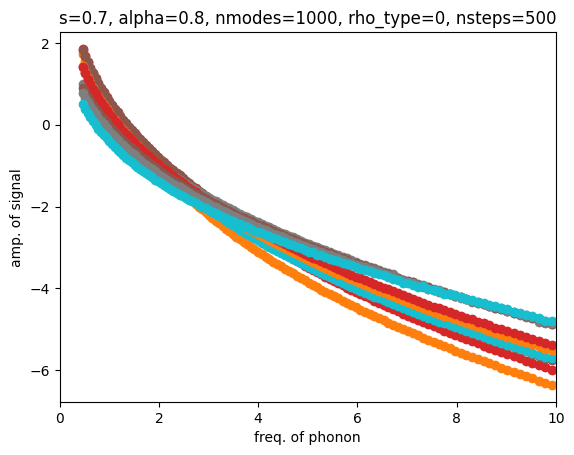

In [36]:



for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in pseudo_coherent_points:
        parms = draw_amp_plot_withlog(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)

In [37]:
coherent_points_amp_degree_results = {}
coherent_points_amp_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in coherent_points:
        # omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nsteps=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        coherent_points_amp_degree_results[key] = buffer
# plt.legend(draggable=True)

In [38]:
for key in coherent_points_amp_degree_results:
    value = coherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.10-alpha0.05, 0.0186, 0.0210
s0.40-alpha0.05, 0.0463, 0.3068
s0.40-alpha0.10, 0.0429, 0.0689
s0.70-alpha0.05, 0.0198, 0.2332
s0.70-alpha0.10, 0.0410, 0.4788


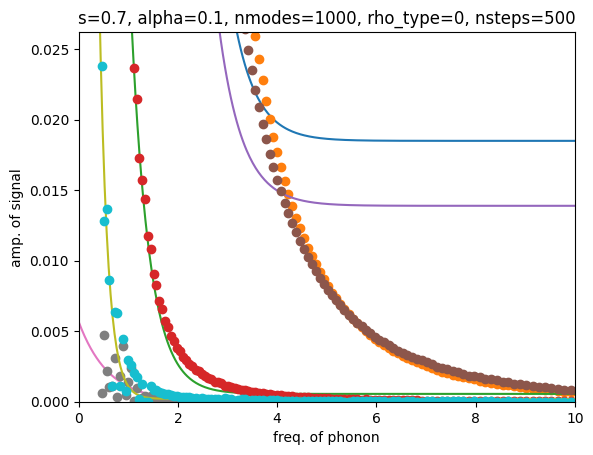

In [39]:
coherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in coherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        coherent_points_amp_fit_results[key] = (a, b, c)

In [40]:
for key in coherent_points_amp_fit_results:
    value = coherent_points_amp_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.10-alpha0.05, 8.5171, -2.1980, 0.0185
s0.40-alpha0.05, 0.4693, -2.7091, 0.0006
s0.40-alpha0.10, 4.7690, -2.0982, 0.0139
s0.70-alpha0.05, 0.0057, -1.6603, -0.0000
s0.70-alpha0.10, 0.3274, -5.9065, 0.0002


In [41]:
incoherent_points_amp_degree_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

    key =job_name
    if (s, alpha) in incoherent_points:
        # omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nsteps=nstep)
        dats = [get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]
    
        buffer = []
        buffer.append([])
        buffer.append([])
        for i in range(dats.__len__()):

            amp_std = np.std(np.array(dats[i][2]))
            amp_mean = np.mean(np.array(dats[i][2]))
            amp_var = np.var(np.array(dats[i][2]))

            degree = amp_var/amp_mean # how fat it is 
            buffer[0].append(amp_var)
            buffer[1].append(degree)
        incoherent_points_amp_degree_results[key] = buffer




In [42]:
incoherent_points_amp_degree_results

{'traj_s0.70_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': [[0.0904628179894148,
   0.07385451045444531,
   0.06457575866585258,
   0.05307696241657082,
   0.04661085336195428,
   0.04090873092949165,
   0.033958569238296855,
   0.029969579467524578,
   0.025054156909029488,
   0.022175520958473888,
   0.018657145640781254,
   0.016572053293320562,
   0.01404420839200082,
   0.012509346627412396,
   0.010645097714479416,
   0.00950852391169341,
   0.008141584358857694,
   0.007296685671903397,
   0.006273438700604659,
   0.005637849658772301,
   0.004874786709196646,
   0.004386484584671036,
   0.0038024620481537583,
   0.0034362956916836884,
   0.002993523479616397,
   0.0027077361989854957,
   0.0023694951330100753,
   0.002148229276953033,
   0.0018897906128234557,
   0.0017146822514441783,
   0.0015073728181555892,
   0.0004235454412035704,
   0.00037476751650161505,
   0.00033878977222285986,
   0.00029806626845065,
   0.000269054034243137,
   0.000238

In [43]:
for key in incoherent_points_amp_degree_results:
    value = incoherent_points_amp_degree_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{max(value[0]):.04f},', f'{max(value[1]):.04f}')

s0.70-alpha0.20, 0.0905, 0.2896
s0.70-alpha0.25, 0.0581, 0.1110
s0.70-alpha0.30, 0.0024, 0.0038
s0.70-alpha0.35, 0.0000, 0.0000
s0.70-alpha0.40, 0.0002, 0.0002
s0.70-alpha0.45, 0.0002, 0.0002


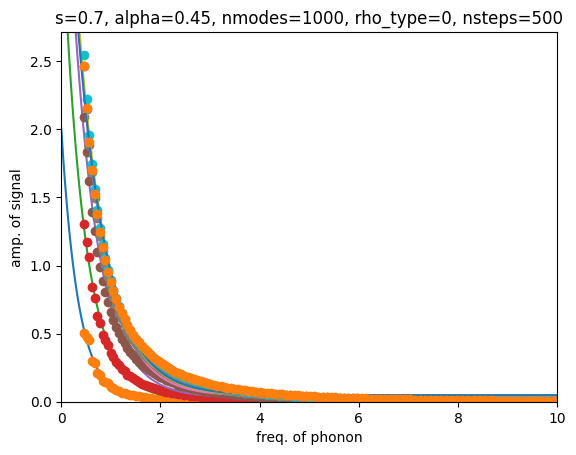

In [44]:
incoherent_points_amp_fit_results = {}
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    # points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    # key = line
    # print(s, alpha)
    if (s, alpha) in incoherent_points:
        parms = draw_amp_plot_withfit(s, alpha, mother_folder, vn_entropy_1site_all_lines, True)
        a = parms[0]
        b = parms[1]
        c = parms[2]
        key = line  

        incoherent_points_amp_fit_results[key] = (a, b, c)

In [45]:
for key in incoherent_points_amp_fit_results:
    value = incoherent_points_amp_fit_results[key]
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(key)
    print(f's{s:.02f}-alpha{alpha:.02f},', f'{value[0]:.04f},', f'{value[1]:.04f},', f'{value[2]:.04f}')

s0.70-alpha0.20, 2.0017, -2.9236, 0.0045
s0.70-alpha0.25, 3.6255, -2.3050, 0.0160
s0.70-alpha0.30, 4.7529, -1.9597, 0.0311
s0.70-alpha0.35, 5.0311, -1.7733, 0.0409
s0.70-alpha0.40, 5.0009, -1.7058, 0.0464
s0.70-alpha0.45, 4.7142, -1.6575, 0.0483


In [46]:
incoherent_points_amp_fit_results

{'traj_s0.70_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (2.0017322536343634,
  -2.9236364630848466,
  0.004534995828191328),
 'traj_s0.70_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (3.6254617223375165,
  -2.3050029407382153,
  0.01604533971839517),
 'traj_s0.70_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (4.75285970574227,
  -1.9596832159887276,
  0.031101686619040086),
 'traj_s0.70_alpha0.35_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (5.031092683586157,
  -1.77332296843185,
  0.040906193675019305),
 'traj_s0.70_alpha0.40_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (5.000924814750752,
  -1.7057771604149643,
  0.04635029305744578),
 'traj_s0.70_alpha0.45_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0': (4.714190051386931,
  -1.6574945532912286,
  0.04834401947055727)}

In [47]:
len(incoherent_points_freq_fit_results) + len(coherent_points_freq_fit_results) + len(pseudo_coherent_points_freq_fit_results)

21

In [48]:
sorted(list(incoherent_points_freq_fit_results.keys()) + list(coherent_points_freq_fit_results.keys()) + list(pseudo_coherent_points_freq_fit_results.keys()))

['traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.50_alpha0.80_Omega1_om

In [49]:
list(vn_entropy_1site_all_lines.keys())

['traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0',
 'traj_s0.40_alpha0.80_Omega1_om

(0.15266334447842397, 0.0766044104552894, 0.9921603105948019)

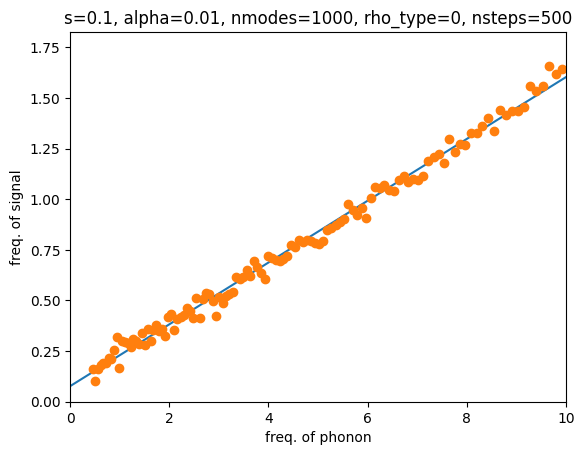

In [50]:
draw_freq_plot_withfit(0.1, 0.01, mother_folder, vn_entropy_1site_all_lines, True)

(0.06563879789799969, -1.8631801581231424, -0.00012288378110847186)

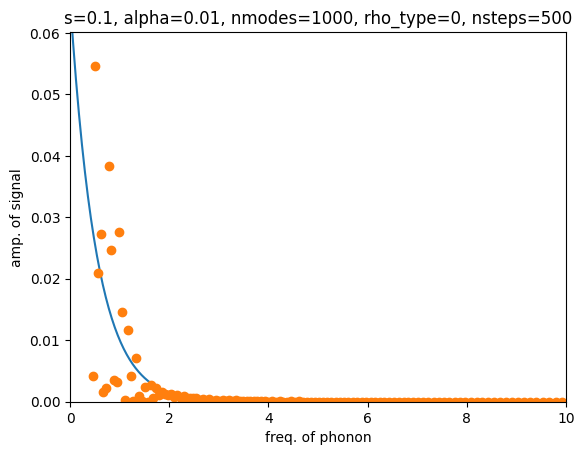

In [51]:
draw_amp_plot_withfit(0.1, 0.01, mother_folder,vn_entropy_1site_all_lines, True)